## Import main functions

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plot
from PIL import Image
import cv2
import random
import seaborn as sns

In [ ]:
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Conv2D, Activation, Add, Conv2DTranspose
from keras.applications.vgg16 import VGG16

## Initialize Variables

After importing the libraries, we initialize all the necessary variables - 
* `train_folder` - Path for training images
* `valid_folder` - Path for testing images
* `width` - Width of an image
* `height` - Height of an image
* `classes` - No. of discrete pixel values in the segmentation maps (no. of labels)
* `batch_size` - Size of a single batch
* `num_of_training_samples` - Total number of training samples
* `num_of_testing_samples` - Total number of testing samples

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_folder="/content/drive/MyDrive/AML Final Project/dataset/dataset_2/train_sr"
valid_folder="/content/drive/MyDrive/AML Final Project/dataset/dataset_2/val_sr"
width = 512
height = 512
classes = 30
batch_size = 4
num_of_training_samples = len(os.listdir(train_folder)) 
num_of_testing_samples = len(os.listdir(valid_folder))

## Helper Functions

For preprocessing the dataset and defining the model, we have defined several helper functions -

* `LoadImage` - Loads a single image and its corresponding segmentation map 
    * **Arguements** :
        * `name` - Name of the image file
        * `path` - Path to the image directory
    * **Returns** - A tuple of 2 numpy arrays (image and segmentation map)
    
    
* `bin_image` - Bin a segmentation map (Converts pixels from range (0, 255) to (0, classes))
    * **Arguements** :
        * `mask` - Original segmentation map
    * **Returns** - New segmentation mask after binning pixel values
    
    
* `getSegmentationArr` - Convert RGB segmentation maps to categorical maps used for training our model
    * **Arguements** :
        * `image` - Segmentation mask after binning
        * `classes` - Number of categories or unique pixel values (13)
        * `width` - Width of segmentation map
        * `height` - Height of segmentation map
    * **Returns** - Categorical segmentation map (width, height, classes)
    
    
* `give_color_to_seg_img` - Convert categorical arrays back to colored segmentation maps
    * **Arguements** : 
        * `seg` - Categorical segmentation map (width, height, classes)
        * `n_classes` - Number of categories or unique pixel values (13) 
    * **Returns** - Colored segmentation map (width, height, 3)
    
    
* `DataGenerator` - Returns data in form of batches
    * **Arguements** :
        * `path` - location or path of the image directory
        * `batch_size` - size of each batch
        * `classes` - Number of categories or unique pixel values (13)
    * **Returns** - Tuple of `batch_size` number of images and segmentation maps
    
    
* `fcn` - Creates the FCN model
    * **Arguements** :
        * `vgg` - VGG16 pretrained model
        * `classes` - Number of categories or unique pixel values (13)
        * `fcn8` - Set True to use FCN-8s model
        * `fcn16` - Set True to use FCN-16s model
    * **Returns** - FCN model
    * **Note** - If both `fcn8` and `fcn16` arguements are set to False, it returns FCN-32s model by default

## Load Image and Segmentation Mask

In [ ]:
def LoadImage(name, path):
    img = Image.open(os.path.join(path, name))
    img = np.array(img)
    
    image = img[:,:512]
    mask = img[:,512:]
    
    return image, mask

## Bin Segmentation Mask 

In [ ]:
def bin_image(mask):
    bins = np.array([20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240])
    new_mask = np.digitize(mask, bins)
    return new_mask

## Segmentation Masks to Categorical Arrays 

In [ ]:
def getSegmentationArr(image, classes, width=width, height=height):
    seg_labels = np.zeros((height, width, classes))
    img = image[:, : , 0]

    for c in range(classes):
        seg_labels[:, :, c] = (img == c ).astype(int)
    return seg_labels

## Categorical Arrays to Colored Segmentation Masks

In [ ]:
def give_color_to_seg_img(seg, n_classes=30):
    
    seg_img = np.zeros( (seg.shape[0],seg.shape[1],3) ).astype('float')
    colors = sns.color_palette("hls", n_classes)
    
    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:,:,0] += (segc*( colors[c][0] ))
        seg_img[:,:,1] += (segc*( colors[c][1] ))
        seg_img[:,:,2] += (segc*( colors[c][2] ))

    return(seg_img)

## Generator function to generate data batches

In [ ]:
def DataGenerator(path, batch_size=4, classes=30):
    files = os.listdir(path)[0:2000]
    while True:
        for i in range(0, len(files), batch_size):
            batch_files = files[i : i+batch_size]
            imgs=[]
            segs=[]
            for file in batch_files:
                #file = random.sample(files,1)[0]
                image, mask = LoadImage(file, path)
                mask_binned = bin_image(mask)
                labels = getSegmentationArr(mask_binned, classes)

                imgs.append(image)
                segs.append(labels)

            yield np.array(imgs), np.array(segs)

## Visualize Data Samples

In [ ]:
train_gen = DataGenerator(train_folder, batch_size=batch_size)
val_gen = DataGenerator(valid_folder, batch_size=batch_size)

In [ ]:
imgs, segs = next(train_gen)
imgs.shape, segs.shape

((4, 512, 512, 3), (4, 512, 512, 30))

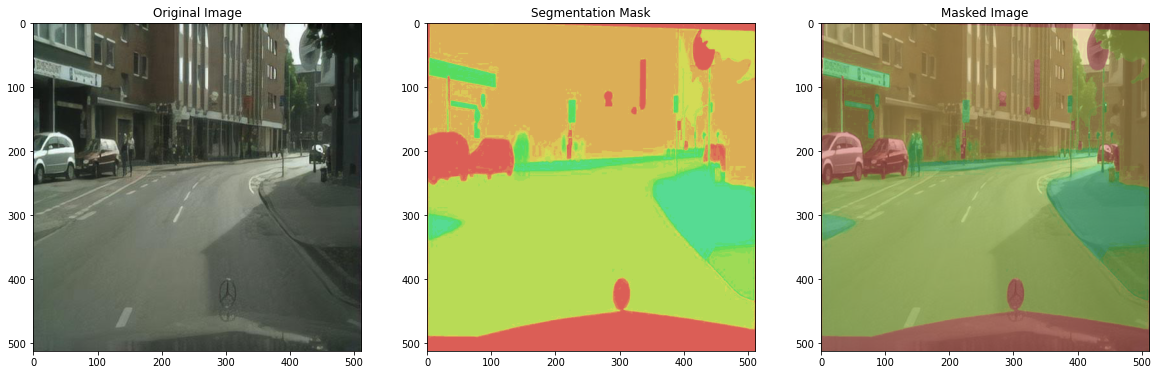

In [ ]:
image = imgs[0]
mask = give_color_to_seg_img(np.argmax(segs[0], axis=-1))
masked_image = cv2.addWeighted(image/255, 0.5, mask, 0.5, 0)

fig, axs = plot.subplots(1, 3, figsize=(20,20))
axs[0].imshow(image)
axs[0].set_title('Original Image')
axs[1].imshow(mask)
axs[1].set_title('Segmentation Mask')
#predimg = cv2.addWeighted(imgs[i]/255, 0.6, _p, 0.4, 0)
axs[2].imshow(masked_image)
axs[2].set_title('Masked Image')
plot.show()

## Segmentation model - FCN+Transfer Learning

In [ ]:
def fcn(vgg, classes = 30, fcn8 = False, fcn16 = False):
    pool5 = vgg.get_layer('block5_pool').output 
    pool4 = vgg.get_layer('block4_pool').output
    pool3 = vgg.get_layer('block3_pool').output
    
    conv_6 = Conv2D(1024, (7, 7), activation='relu', padding='same', name="conv_6")(pool5)
    conv_7 = Conv2D(1024, (1, 1), activation='relu', padding='same', name="conv_7")(conv_6)
  
    conv_8 = Conv2D(classes, (1, 1), activation='relu', padding='same', name="conv_8")(pool4)
    conv_9 = Conv2D(classes, (1, 1), activation='relu', padding='same', name="conv_9")(pool3)
    
    deconv_7 = Conv2DTranspose(classes, kernel_size=(2,2), strides=(2,2))(conv_7)
    add_1 = Add()([deconv_7, conv_8])
    deconv_8 = Conv2DTranspose(classes, kernel_size=(2,2), strides=(2,2))(add_1)
    add_2 = Add()([deconv_8, conv_9])
    deconv_9 = Conv2DTranspose(classes, kernel_size=(8,8), strides=(8,8))(add_2)
    
    if fcn8 :
        output_layer = Activation('softmax')(deconv_9)
    elif fcn16 :
        deconv_10 = Conv2DTranspose(classes, kernel_size=(16,16), strides=(16,16))(add_1)
        output_layer = Activation('softmax')(deconv_10)
    else :
        deconv_11 = Conv2DTranspose(classes, kernel_size=(32,32), strides=(32,32))(conv_7)
        output_layer = Activation('softmax')(deconv_11)
    
    model = Model(inputs=vgg.input, outputs=output_layer)
    return model

In [ ]:
vgg = VGG16(include_top=False, weights='imagenet', input_shape=(width, height, 3))

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
model = fcn(vgg, fcn16=True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 512, 512, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

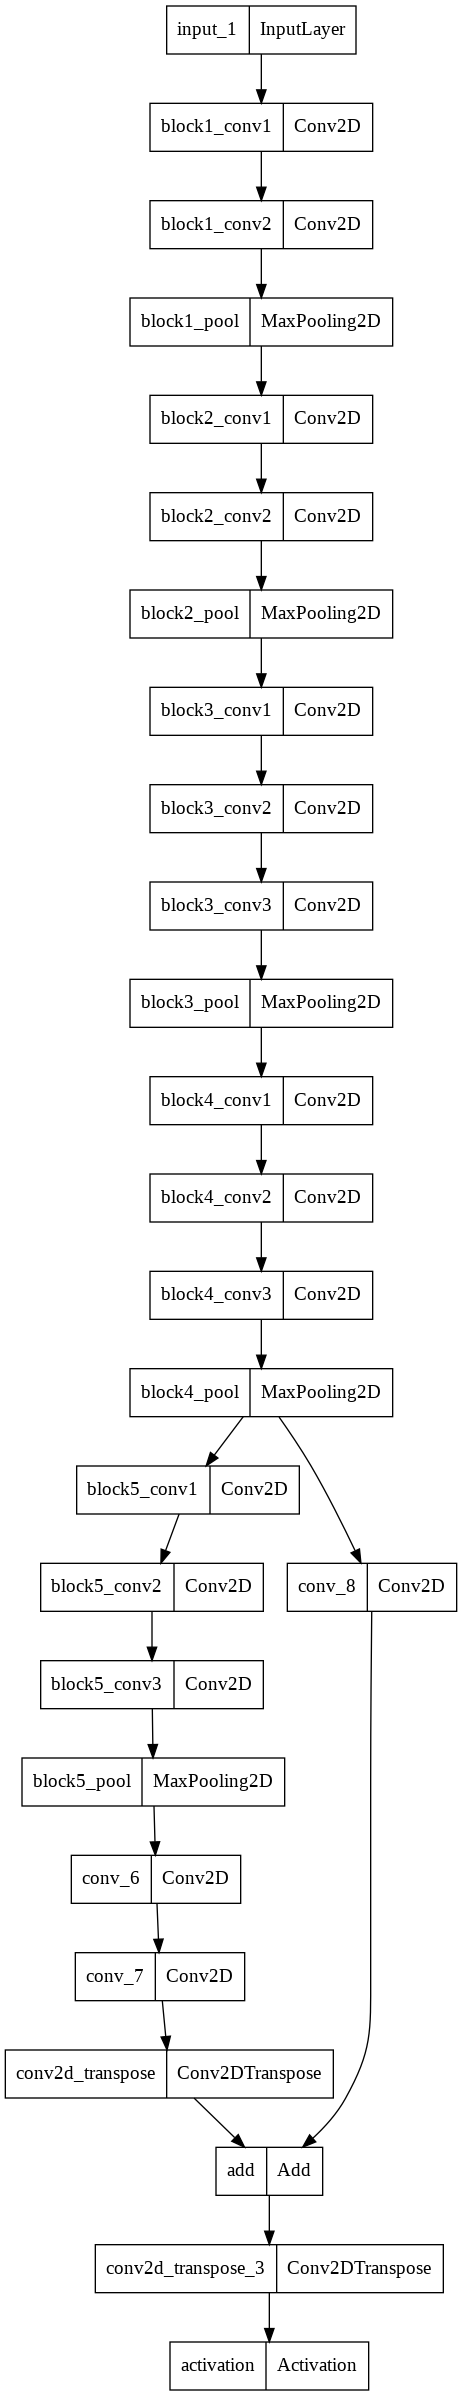

In [ ]:
plot_model(model)

## Train our model

In [ ]:
adam = Adam(lr=0.0001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
filepath = "/content/drive/MyDrive/AML Final Project/Code/others/transfer learning/best-model-vgg.e5c30"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit_generator(train_gen, epochs=5, steps_per_epoch=num_of_training_samples//batch_size,
                       validation_data=val_gen, validation_steps=num_of_testing_samples//batch_size,
                       callbacks=callbacks_list, use_multiprocessing=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/5
744/744 [==============================] - ETA: 0s - loss: 1.3746 - accuracy: 0.6005
Epoch 00001: val_accuracy improved from -inf to 0.70386, saving model to /content/drive/MyDrive/AML Final Project/Code/others/transfer learning/best-model-vgg.e5c30
INFO:tensorflow:Assets written to: /content/drive/MyDrive/AML Final Project/Code/others/transfer learning/best-model-vgg.e5c30/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


744/744 [==============================] - 994s 1s/step - loss: 1.3746 - accuracy: 0.6005 - val_loss: 1.0786 - val_accuracy: 0.7039
Epoch 2/5
744/744 [==============================] - ETA: 0s - loss: 0.8625 - accuracy: 0.7547
Epoch 00002: val_accuracy improved from 0.70386 to 0.75740, saving model to /content/drive/MyDrive/AML Final Project/Code/others/transfer learning/best-model-vgg.e5c30
INFO:tensorflow:Assets written to: /content/drive/MyDrive/AML Final Project/Code/others/transfer learning/best-model-vgg.e5c30/assets
744/744 [==============================] - 934s 1s/step - loss: 0.8625 - accuracy: 0.7547 - val_loss: 0.8264 - val_accuracy: 0.7574
Epoch 3/5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


744/744 [==============================] - ETA: 0s - loss: 0.7234 - accuracy: 0.7871
Epoch 00003: val_accuracy improved from 0.75740 to 0.77210, saving model to /content/drive/MyDrive/AML Final Project/Code/others/transfer learning/best-model-vgg.e5c30
INFO:tensorflow:Assets written to: /content/drive/MyDrive/AML Final Project/Code/others/transfer learning/best-model-vgg.e5c30/assets
744/744 [==============================] - 952s 1s/step - loss: 0.7234 - accuracy: 0.7871 - val_loss: 0.7672 - val_accuracy: 0.7721
Epoch 4/5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


744/744 [==============================] - ETA: 0s - loss: 0.6787 - accuracy: 0.7972
Epoch 00004: val_accuracy did not improve from 0.77210
744/744 [==============================] - 966s 1s/step - loss: 0.6787 - accuracy: 0.7972 - val_loss: 0.8133 - val_accuracy: 0.7687
Epoch 5/5
744/744 [==============================] - ETA: 0s - loss: 0.6265 - accuracy: 0.8095
Epoch 00005: val_accuracy improved from 0.77210 to 0.77981, saving model to /content/drive/MyDrive/AML Final Project/Code/others/transfer learning/best-model-vgg.e5c30
INFO:tensorflow:Assets written to: /content/drive/MyDrive/AML Final Project/Code/others/transfer learning/best-model-vgg.e5c30/assets
744/744 [==============================] - 995s 1s/step - loss: 0.6265 - accuracy: 0.8095 - val_loss: 0.7614 - val_accuracy: 0.7798


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


## Validation and Vizualization

In [ ]:
model.load_weights("/content/drive/MyDrive/AML Final Project/Code/others/transfer learning/best-model-vgg.e5c30")

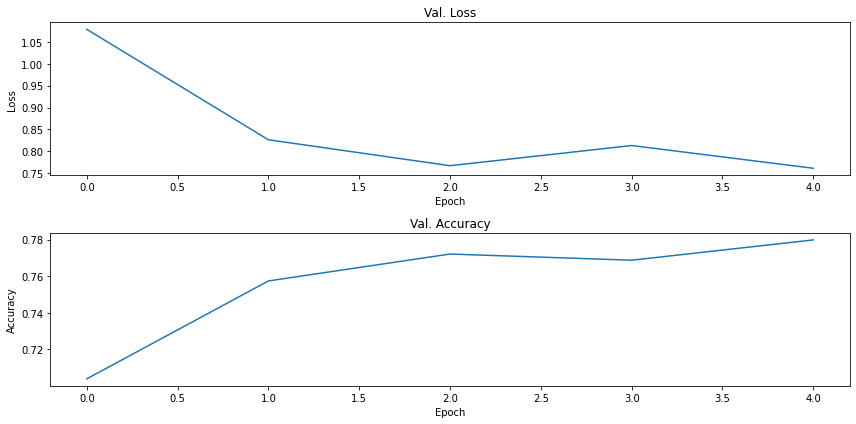

In [ ]:
loss = history.history["val_loss"]
acc = history.history["val_accuracy"] #accuracy

plot.figure(figsize=(12, 6))
plot.subplot(211)
plot.title("Val. Loss")
plot.plot(loss)
plot.xlabel("Epoch")
plot.ylabel("Loss")

plot.subplot(212)
plot.title("Val. Accuracy")
plot.plot(acc)
plot.xlabel("Epoch")
plot.ylabel("Accuracy")

plot.tight_layout()
plot.savefig("learn.png", dpi=150)
plot.show()

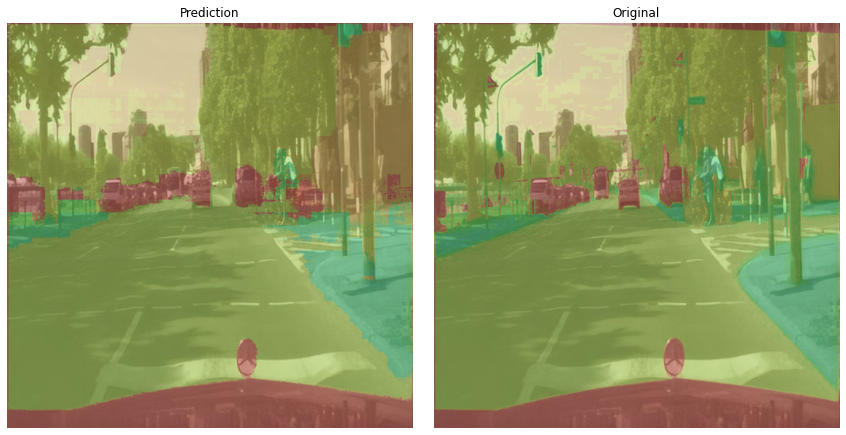

In [ ]:
#val_gen = DataGenerator(valid_folder)
max_show = 1
imgs, segs = next(val_gen)
pred = model.predict(imgs)

for i in range(max_show):
    _p = give_color_to_seg_img(np.argmax(pred[i], axis=-1))
    _s = give_color_to_seg_img(np.argmax(segs[i], axis=-1))

    predimg = cv2.addWeighted(imgs[i]/255, 0.5, _p, 0.5, 0)
    trueimg = cv2.addWeighted(imgs[i]/255, 0.5, _s, 0.5, 0)
    
    plot.figure(figsize=(12,6))
    plot.subplot(121)
    plot.title("Prediction")
    plot.imshow(predimg)
    plot.axis("off")
    plot.subplot(122)
    plot.title("Original")
    plot.imshow(trueimg)
    plot.axis("off")
    plot.tight_layout()
    plot.savefig("pred_"+str(i)+".png", dpi=150)
    plot.show()

In [ ]:
dice_coef(trueimg,predimg)

<tf.Tensor: shape=(), dtype=float64, numpy=0.5353557576707322>

In [ ]:
dice_coef_loss(trueimg,predimg)

<tf.Tensor: shape=(), dtype=float64, numpy=0.4646442423292678>

In [ ]:
iou(trueimg,predimg)

<tf.Tensor: shape=(), dtype=float64, numpy=0.3655198860243709>

In [ ]:
jac_distance(trueimg,predimg)

<tf.Tensor: shape=(), dtype=float64, numpy=0.6344801139756291>

## References

* [Fully Convolutional Networks for Semantic Segmentation](https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Long_Fully_Convolutional_Networks_2015_CVPR_paper.pdf)
* [Fully Convolutional Networks (FCN) for 2D segmentation](http://www.deeplearning.net/tutorial/fcn_2D_segm.html)
* [Learn about Fully Convolutional Networks for semantic segmentation](https://fairyonice.github.io/Learn-about-Fully-Convolutional-Networks-for-semantic-segmentation.html)
* [An Introduction to different Types of Convolutions in Deep Learning](https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d)